Practicing dropout with different parameters

In [6]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import mlflow
import mlflow.pytorch

transform = transforms.ToTensor()
full_train_data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

train_size = int(0.8 * len(full_train_data))  # 48,000
val_size = len(full_train_data) - train_size  # 12,000

train_data, val_data = random_split(full_train_data, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)


In [7]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 2)

In [8]:
class DropoutModel(nn.Module):
    def __init__(self, p1, p2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=p1),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=p2),
            nn.Linear(in_features=64, out_features=10)
        )
    
    def forward(self, x):
        return self.net(x)

In [21]:
dropout_p1 = 0.2
dropout_p2 = 0.2
lr = 0.01

model = DropoutModel(dropout_p1, dropout_p2)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

epochs = 20

mlflow.set_tracking_uri("mlruns")
with mlflow.start_run(run_name=f"{dropout_p1} {dropout_p2} Long"):

    # Log hyperparameters
    mlflow.log_param("dropout_p1", dropout_p1)
    mlflow.log_param("dropout_p2", dropout_p2)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", lr)

    for epoch in range(epochs):
        model.train()
        correct = 0
        total_loss = 0
        
        for xb, yb in train_loader:
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss * xb.size(0)
            preds = yhat.argmax(dim=1)
            correct += (preds == yb).sum().item()

        train_acc = correct / len(train_loader.dataset)
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                yhat = model(xb)
                preds = yhat.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_acc = correct / total
        avg_train_loss = total_loss / len(train_loader.dataset)

        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)
        mlflow.log_metric("train_loss", total_loss / len(train_loader.dataset), step=epoch)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

Epoch 1: Train Acc = 0.3495, Val Acc = 0.5842
Epoch 2: Train Acc = 0.5712, Val Acc = 0.6719
Epoch 3: Train Acc = 0.6456, Val Acc = 0.7043
Epoch 4: Train Acc = 0.6858, Val Acc = 0.7297
Epoch 5: Train Acc = 0.7140, Val Acc = 0.7505
Epoch 6: Train Acc = 0.7402, Val Acc = 0.7740
Epoch 7: Train Acc = 0.7568, Val Acc = 0.7871
Epoch 8: Train Acc = 0.7687, Val Acc = 0.7992
Epoch 9: Train Acc = 0.7810, Val Acc = 0.8048
Epoch 10: Train Acc = 0.7891, Val Acc = 0.8097
Epoch 11: Train Acc = 0.7957, Val Acc = 0.8123
Epoch 12: Train Acc = 0.8012, Val Acc = 0.8193
Epoch 13: Train Acc = 0.8080, Val Acc = 0.8249
Epoch 14: Train Acc = 0.8111, Val Acc = 0.8287
Epoch 15: Train Acc = 0.8145, Val Acc = 0.8303
Epoch 16: Train Acc = 0.8202, Val Acc = 0.8336
Epoch 17: Train Acc = 0.8194, Val Acc = 0.8347
Epoch 18: Train Acc = 0.8235, Val Acc = 0.8375
Epoch 19: Train Acc = 0.8255, Val Acc = 0.8387
Epoch 20: Train Acc = 0.8277, Val Acc = 0.8405


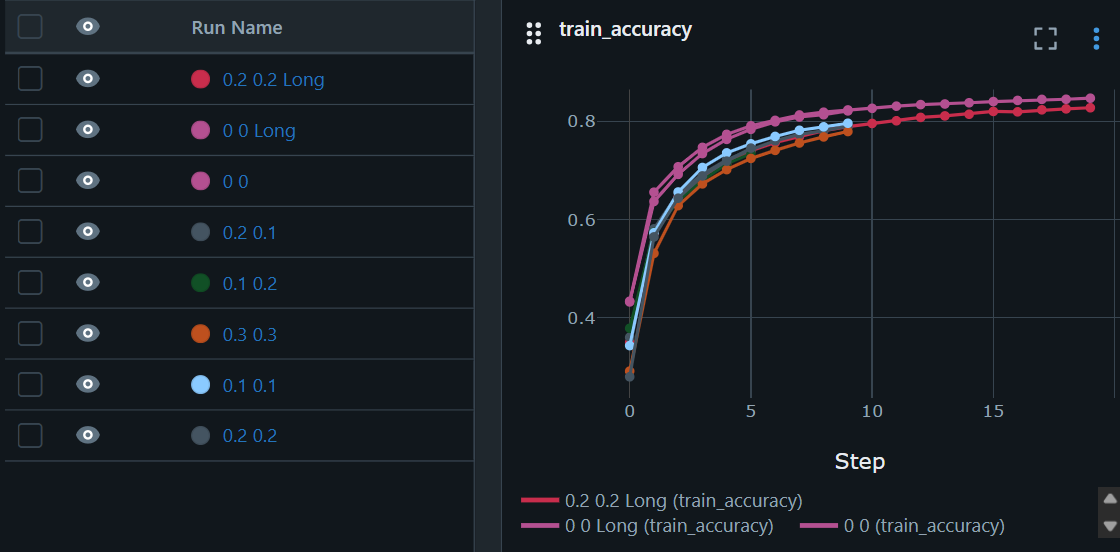

In [23]:
from IPython.display import Image
Image('figures/train_acc.png')

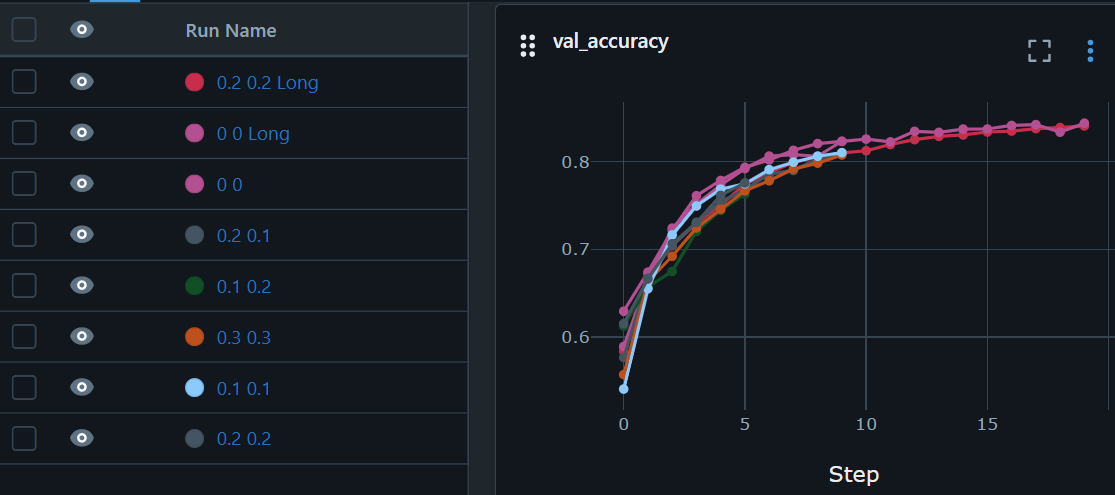

In [24]:
Image('figures/val_acc.png')